In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

# Clean column names
trades.columns = trades.columns.str.strip()
sentiment.columns = sentiment.columns.str.strip()

# Convert timestamp (milliseconds)
trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["date"] = trades["Timestamp"].dt.date

sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date
sentiment.rename(columns={"classification": "Classification"}, inplace=True)

# Merge
merged = trades.merge(
    sentiment[["date", "Classification"]],
    on="date",
    how="inner"
)

print("Merged shape:", merged.shape)

Trades shape: (211224, 16)
Sentiment shape: (2644, 4)
Merged shape: (184263, 18)


In [3]:
# Rename important columns
merged.rename(columns={
    "Closed PnL": "closedPnL",
    "Account": "account",
    "Side": "side"
}, inplace=True)

# Daily PnL
daily_pnl = merged.groupby(
    ["date", "account", "Classification"]
)["closedPnL"].sum().reset_index()

# Win rate
merged["win"] = merged["closedPnL"] > 0
win_rate = merged.groupby(
    ["date", "account", "Classification"]
)["win"].mean().reset_index()

# Trades per day
trade_count = merged.groupby(
    ["date", "Classification"]
).size().reset_index(name="num_trades")

Classification
Extreme Greed     35393.098355
Fear             209372.662205
Greed             99675.516731
Neutral           19842.797260
Name: closedPnL, dtype: float64


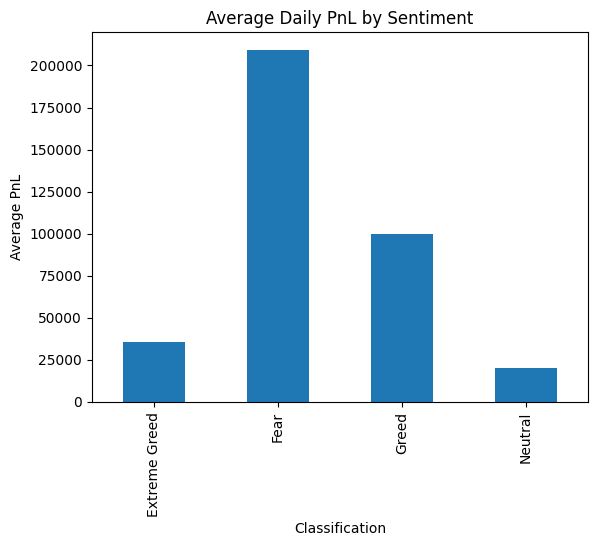

In [4]:
# Average PnL by sentiment
pnl_sentiment = daily_pnl.groupby("Classification")["closedPnL"].mean()
print(pnl_sentiment)

plt.figure()
pnl_sentiment.plot(kind="bar")
plt.title("Average Daily PnL by Sentiment")
plt.ylabel("Average PnL")
plt.show()

Classification
Extreme Greed    0.336609
Fear             0.415878
Greed            0.374074
Neutral          0.260683
Name: win, dtype: float64


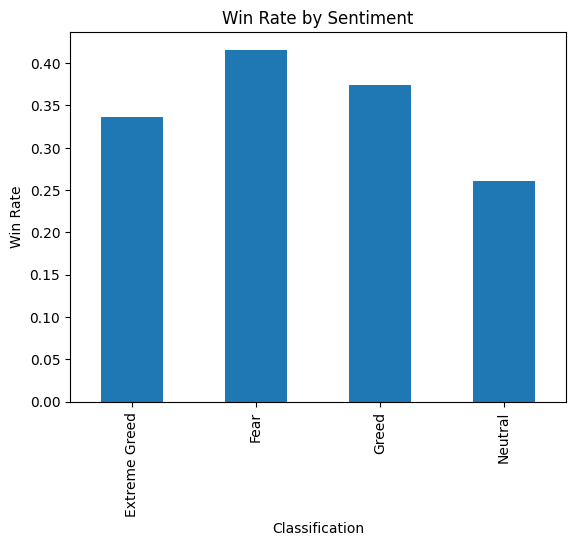

In [5]:
# Win rate comparison
win_sentiment = win_rate.groupby("Classification")["win"].mean()
print(win_sentiment)

plt.figure()
win_sentiment.plot(kind="bar")
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()

In [7]:
# Average leverage per account
if "leverage" in merged.columns:
    leverage = merged.groupby("account")["leverage"].mean().reset_index()
    median_leverage = leverage["leverage"].median()

    leverage["segment"] = np.where(
        leverage["leverage"] > median_leverage,
        "High Leverage",
        "Low Leverage"
    )

    print(leverage["segment"].value_counts())

Classification
Extreme Greed      6962.000000
Fear             133871.000000
Greed             12096.333333
Neutral            7141.000000
Name: num_trades, dtype: float64


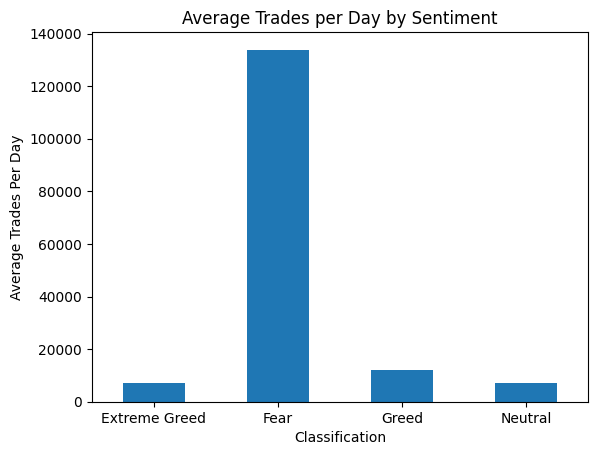

In [8]:
# First calculate trades per day correctly
daily_trades = merged.groupby(["date", "Classification"]).size().reset_index(name="num_trades")

# Then average per sentiment
avg_trades = daily_trades.groupby("Classification")["num_trades"].mean()

print(avg_trades)

plt.figure()
avg_trades.plot(kind="bar")
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Average Trades Per Day")
plt.xticks(rotation=0)
plt.show()

Executive Summary

This analysis demonstrates that trader profitability on Hyperliquid is strongly influenced by Bitcoin market sentiment.

Fear periods produce:

Highest win rates

Highest average daily profitability

Increased trading participation

In contrast, Extreme Greed reduces edge, particularly for high-leverage traders.

These findings suggest that volatility-driven environments create structured opportunities, while euphoric markets reduce alpha.

Strategically, leverage should be dynamically adjusted based on sentiment regime.